### LOAD DATA

In [1]:
import tensorflow as tf
from pathlib import Path
from src.datagen import FrameGenerator

# SETTINGS
TRAIN_PATH = Path('data/vids/split/train')
TEST_PATH = Path('data/vids/split/test')
FRAMES_PER_VIDEO = 100

# CREATE TRAINING DATASET
output_signature = (tf.TensorSpec(shape = (None, None, None, 3), dtype = tf.float32), tf.TensorSpec(shape = (1), dtype = tf.int16))
train_ds = tf.data.Dataset.from_generator(FrameGenerator(TRAIN_PATH, FRAMES_PER_VIDEO, training=True),output_signature = output_signature)

# CREATE TESTING DATASET
test_ds = tf.data.Dataset.from_generator(FrameGenerator(TEST_PATH, FRAMES_PER_VIDEO, training=False),output_signature = output_signature)

# VERIFY DATA HAS CORRECT SHAPE
train_frames, train_labels = next(iter(train_ds))
print(f'Shape of training set of frames: {train_frames.shape}')
print(f'Shape of training labels: {train_labels.shape}')

test_frames, test_labels = next(iter(test_ds))
print(f'Shape of validation set of frames: {test_frames.shape}')
print(f'Shape of validation labels: {test_labels.shape}')

Detected Labels:  {'fake': 0, 'real': 1}
Detected Labels:  {'fake': 0, 'real': 1}
Shape of training set of frames: (10, 256, 256, 3)
Shape of training labels: (1,)
Shape of validation set of frames: (10, 256, 256, 3)
Shape of validation labels: (1,)


### INITIALIZE MODEL

In [2]:
from src.models import get_mouthnet_model, get_mesonet_model, get_cnn_rnn_hybrid
from src.train import load_model_from_path

# SETTINGS
MODEL_NAME = "MESONET"
EPOCHS = 1
BATCH_SIZE = 10
OPTIMIZER = "adam"
PRETRAINED = False

if not PRETRAINED:
    # LOAD NEW MODEL
    model = get_mesonet_model()
else:
    # LOAD MODEL WEIGHTS FROM FILE
    model = load_model_from_path(f"saved_models/{MODEL_NAME}.keras")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 256, 256, 8)    │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256, 256, 8)    │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 8)    │         1,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 8)    │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 16)     │         3,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 16)     │         6,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 32, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │        16,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,073 (109.66 KB)

 Trainable params: 27,977 (109.29 KB)

 Non-trainable params: 96 (384.00 B)

### TRAIN MODEL
Will automatically save model (under saved_models/MODEL_NAME.keras) whenever new maximum validation accuracy reached.

In [6]:
from src.train import prep_and_train_model, save_history
from time import perf_counter

start = perf_counter()

history, model = prep_and_train_model(
    model=model,
    optim=OPTIMIZER,
    train_data=train_ds,
    test_data=test_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    model_name=MODEL_NAME
)

print(f"TOTAL TRAIN TIME: {perf_counter() - start}")

# SAVE HISTORY TO FILE
save_history(history, MODEL_NAME)

    235/Unknown 84s 347ms/step - accuracy: 0.6505 - loss: 0.6475

C:\Users\MaxHu\anaconda3\envs\opencv_env\lib\contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


235/235 ━━━━━━━━━━━━━━━━━━━━ 99s 412ms/step - accuracy: 0.6505 - loss: 0.6475 - val_accuracy: 0.7283 - val_loss: 0.5867
TOTAL TRAIN TIME: 99.2156001000003


### VISUALIZE TRAINING HISTORY

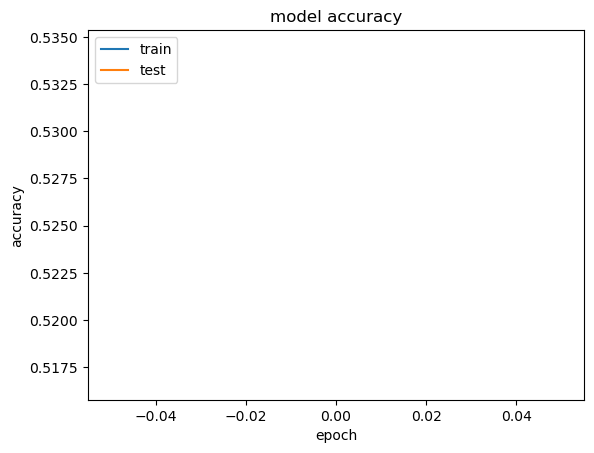

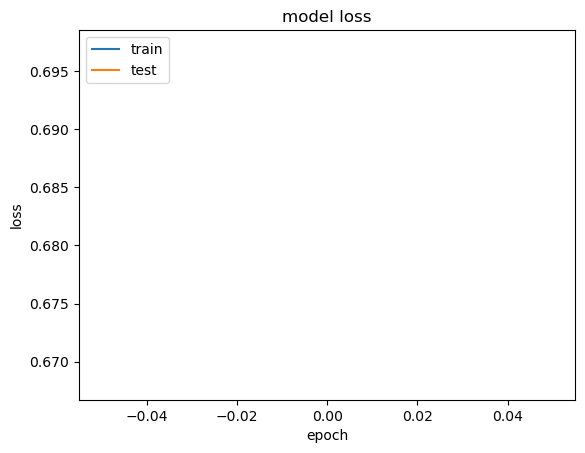

In [5]:
import matplotlib.pyplot as plt

# NOTE: ONLY WORKS FOR MULTIPLE EPOCHS

# PLOT ACCURACY
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# PLOT LOSS
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()